# 1. Finding the Max Sharpe Ratio Portfolio

We've already seen that given a set of expected returns and a covariance matrix, we can plot the efficient frontier. In this section, we'll extend the code to locate the point on the efficient frontier that we are most interested in, which is the tangency portfolio or the Max Sharpe Ratio portfolio.

Let's start by the usual imports, and load in the data.

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import edhec_risk_kit as erk

ind = erk.get_ind_returns()
er = erk.annualize_rets(ind["1996":"2000"], 12)
cov = ind["1996":"2000"].cov()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We already know how to identify points on the curve if we are given a target rate of return. Instead of minimizing the vol based on a target return, we want to find that one point on the curve that maximizes the Sharpe Ratio, given the risk free rate.

```python
def msr(riskfree_rate, er, cov):
    """
    Returns the weights of the portfolio that gives you the maximum sharpe ratio
    given the riskfree rate and expected returns and a covariance matrix
    RiskFree + ER + COV -> W
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def neg_sharpe(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the sharpe ratio
        of the given portfolio
        """
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r - riskfree_rate)/vol
    
    weights = minimize(neg_sharpe, init_guess,
                       args=(riskfree_rate, er, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x
```

Let's guess where the point might be:

(0.0, 0.1417836627988211)

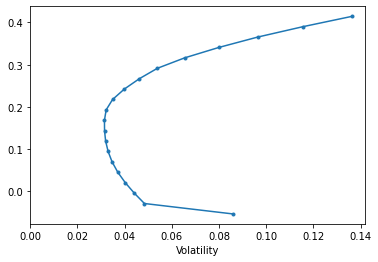

In [8]:
ax = erk.plot_ef(20, er, cov)
ax.set_xlim(left = 0)

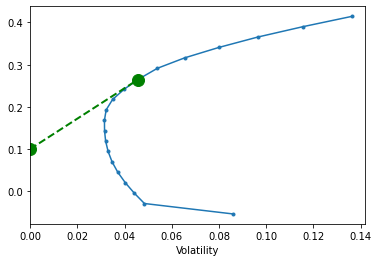

In [9]:
# plot EF
ax = erk.plot_ef(20, er, cov)
ax.set_xlim(left = 0)
# get MSR
rf = 0.1
w_msr = erk.msr(rf, er, cov)
r_msr = erk.portfolio_return(w_msr, er)
vol_msr = erk.portfolio_vol(w_msr, cov)
# add CML (Capital Market Line)
cml_x = [0, vol_msr]
cml_y = [rf, r_msr]
ax.plot(cml_x, cml_y, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12)

<AxesSubplot:xlabel='Volatility'>

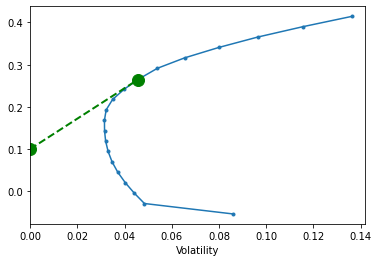

In [11]:
erk.plot_ef(20, er, cov, show_cml = True, riskfree_rate = 0.1)

# 2.  Lack of Robustness of the Markowitz procedure and the GMV (Global Minimum Variance) portfolio

Although the promise of the Markowitz procedure is exciting, in tends to fall apart in practice. The problem is that we rarely know Expected Returns and Expected Covariance in advance. Our estimates almost certainly contain some estimation error, and we'll see that the procedure is highly sensitive to these errors, which tend to get exaggerated in the portfolio.

To see this, let's start by loading up our data as usual.

In [13]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import edhec_risk_kit as erk

ind = erk.get_ind_returns()
er = erk.annualize_rets(ind["1996":"2000"], 12)
cov = ind["1996":"2000"].cov()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's look at a simple 2-asset portfolio and find the optimal weights if we had known what the returns would be.

In [16]:
l = ["Food", "Steel"]
erk.msr(0.1, np.array(er[l]), cov.loc[l,l])

array([0.75040363, 0.24959637])

Let's look at the returns of the two assets that dictated those weights

In [17]:
er[l]

Food     0.116799
Steel    0.115809
dtype: float64

Now assume that we had a really good estimator, and we were off by only a fraction of a percent in our estimate, and we had estimated a return of 11 and 12 percent respectively for Food and Steel

In [18]:
erk.msr(0.1, np.array([.11, .12]), cov.loc[l,l])

array([0.57930354, 0.42069646])

We see that even a small change in the estimate causes a major change in the weights. What if we were off by around 1% to 2% percent in each estimate and estimated 10% and 13% instead of the return of 11.6% and 11.5%?

In [19]:
erk.msr(0.1, np.array([.10, .13]), cov.loc[l,l])

array([0., 1.])

And if we had made the _same_ estimation error, but the error went the other way (13% and 10%)?

In [21]:
erk.msr(0.1, np.array([.13, .10]), cov.loc[l,l])

array([1.0000000e+00, 6.9388939e-18])

# Avoiding estimating returns

Let's look at the efficient frontier one more time, and plot the efficient frontier again.


<AxesSubplot:xlabel='Volatility'>

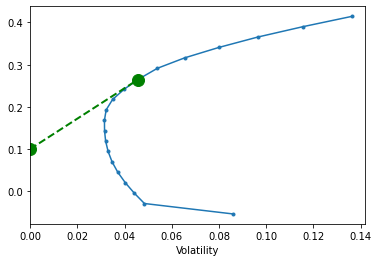

In [22]:
erk.plot_ef(20, er, cov, show_cml=True, riskfree_rate=0.1)

One way to avoid this estimation game is to skip the entire process and just rely on _naive_ diversification, which means hold all stocks with equal weight. We can add the EW (equal weighted) portfolio to the plot by enhancing the `plot_ef` function as follows:

```python
    if show_ew:
        n = er.shape[0]
        w_ew = np.repeat(1/n, n)
        r_ew = portfolio_return(w_ew, er)
        vol_ew = portfolio_vol(w_ew, cov)
        # add EW
        ax.plot([vol_ew], [r_ew], color='goldenrod', marker='o', markersize=10)
```


<AxesSubplot:xlabel='Volatility'>

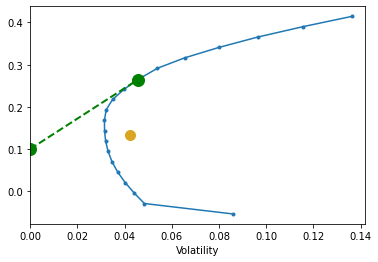

In [23]:
erk.plot_ef(20, er, cov, show_cml=True, riskfree_rate=0.1, show_ew=True)

Researchers have shown that the EW portfolio is a remarkably good portfolio to hold. In fact, there is overwhelming support for the idea that it is a far better portfolio to hold than a cap-weighted equivalent. We'll examine this in later sections, but as you can see, the EW portfolio is far inside the efficient frontier, but it requires no estimation whatsoever.

However, there is another point on the efficient frontier that is very interesting. This is the _nose_ of the hull, which is the portfolio of lowest volatility across all possible portfolios. This is called the Minimum Volatility or the Global Minimum Volatility or GMV portfolio.

But how do we find the weights of the GMV portfolio?

The interesting thing about it is that if you assume that all returns are the same, the optimizer cannot improve the sharpe ratio through raising returns, and so it must do so my lowering volatility. This means that if we just skip any returns estimation and assume all returns have the return, we'd get the weights of the GMV portfolio!

```python
def gmv(cov):
    """
    Returns the weights of the Global Minimum Volatility portfolio
    given a covariance matrix
    """
    n = cov.shape[0]
    return msr(0, np.repeat(1, n), cov)
```

and we can add that to the plot as follows:

```python
    if show_gmv:
        w_gmv = gmv(cov)
        r_gmv = portfolio_return(w_gmv, er)
        vol_gmv = portfolio_vol(w_gmv, cov)
        # add EW
        ax.plot([vol_gmv], [r_gmv], color='midnightblue', marker='o', markersize=10)
```


<AxesSubplot:xlabel='Volatility'>

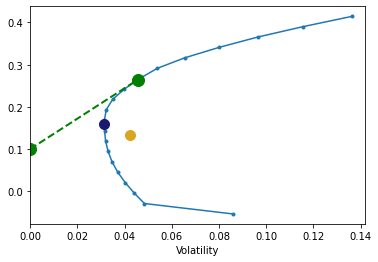

In [24]:
erk.plot_ef(20, er, cov, show_cml=True, riskfree_rate=0.1, show_ew=True, show_gmv=True)

at MSR portfolio point is what we want to be but unless we have good estimator, it is really hard to get there because a little change in expected return can change the point a lot. So we can look at EW and GMV portfolio wihout estimator needed.

## For the quiz

#### Question 1-3

In [31]:
hfi["2000":].head()

,Convertible Arbitrage,CTA Global,Distressed Securities,Emerging Markets,Equity Market Neutral,Event Driven,Fixed Income Arbitrage,Global Macro,Long/Short Equity,Merger Arbitrage,Relative Value,Short Selling,Funds Of Funds
date,,,,,,,,,,,,,
2000-01,0.0227,0.0128,0.0088,0.0077,0.0075,0.0088,0.0041,0.0021,0.0075,0.0143,0.0173,0.0427,0.0169
2000-02,0.0267,-0.0022,0.0421,0.0528,0.0253,0.0346,0.0097,0.0408,0.0699,0.0239,0.0185,-0.1340,0.0666
2000-03,0.0243,-0.0138,0.0103,0.0318,0.0134,0.0069,-0.0061,-0.0104,0.0006,0.0131,0.0163,-0.0230,0.0039
2000-04,0.0223,-0.0241,-0.0101,-0.0541,0.0168,-0.0059,-0.0006,-0.0304,-0.0201,0.0188,0.0092,0.1028,-0.0269
2000-05,0.0149,0.0114,-0.0132,-0.0433,0.0062,-0.0034,0.0107,-0.0070,-0.0097,0.0146,0.0080,0.0704,-0.0122


In [26]:
hfi = erk.get_hfi_returns()

C:\Users\NGUYEN Xuan Vinh\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\parsers\base_parser.py:1070: UserWarning: Parsing '31/01/1997' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return tools.to_datetime(
C:\Users\NGUYEN Xuan Vinh\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\parsers\base_parser.py:1070: UserWarning: Parsing '28/02/1997' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return tools.to_datetime(
C:\Users\NGUYEN Xuan Vinh\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\parsers\base_parser.py:1070: UserWarning: Parsing '31/03/1997' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return tools.to_datetime(
C:\Users\NGUYEN Xuan Vinh\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\parsers\base_parser.py:1070: UserWarning: Parsing '30/

In [32]:
erk.var_gaussian(hfi["2000":], level = 1)

Convertible Arbitrage     0.034845
CTA Global                0.050336
Distressed Securities     0.031430
Emerging Markets          0.058070
Equity Market Neutral     0.014772
Event Driven              0.030853
Fixed Income Arbitrage    0.019519
Global Macro              0.024619
Long/Short Equity         0.039420
Merger Arbitrage          0.015355
Relative Value            0.021605
Short Selling             0.102130
Funds Of Funds            0.029385
dtype: float64

In [33]:
erk.var_gaussian(hfi["2000":], level = 1, modified=True)

Convertible Arbitrage     0.103666
CTA Global                0.046643
Distressed Securities     0.049669
Emerging Markets          0.086796
Equity Market Neutral     0.041432
Event Driven              0.045732
Fixed Income Arbitrage    0.066479
Global Macro              0.022786
Long/Short Equity         0.051381
Merger Arbitrage          0.021282
Relative Value            0.048985
Short Selling             0.098323
Funds Of Funds            0.048793
dtype: float64

In [34]:
erk.var_historic(hfi["2000":], level = 1)

Convertible Arbitrage     0.031674
CTA Global                0.050938
Distressed Securities     0.042642
Emerging Markets          0.065496
Equity Market Neutral     0.019800
Event Driven              0.038540
Fixed Income Arbitrage    0.030748
Global Macro              0.022632
Long/Short Equity         0.045060
Merger Arbitrage          0.022654
Relative Value            0.021788
Short Selling             0.107684
Funds Of Funds            0.027200
dtype: float64

In [35]:
ind = erk.get_ind_returns()
er = erk.annualize_rets(ind["2013":"2017"], 12)
cov = ind["2013":"2017"].cov()

In [37]:
ind.shape

(1110, 30)

In [74]:
l = ["Books", "Steel", "Oil", "Mines"]

In [77]:
erk.msr(0.1, er[l], cov.loc[l,l])

array([0.00000000e+00, 1.00000000e+00, 2.48065457e-16, 6.44449771e-16])

In [49]:
import pandas as pd

In [52]:
pd.DataFrame(data = {'ind' : er.index, 'weigh': erk.msr(0.1, er, cov)} ).sort_values(by = 'weigh')

,ind,weigh
14,Autos,0.000000e+00
4,Books,0.000000e+00
18,Oil,0.000000e+00
17,Coal,0.000000e+00
10,Cnstr,0.000000e+00
11,Steel,0.000000e+00
13,ElcEq,0.000000e+00
16,Mines,0.000000e+00
8,Chems,1.539639e-14
25,Whlsl,1.804831e-14


In [83]:
erk.gmv(cov.loc[l,l])

array([4.77024876e-01, 6.50521303e-19, 4.34112019e-01, 8.88631054e-02])

In [54]:
pd.DataFrame(data = {'ind' : er.index, 'weigh': erk.gmv(cov)} ).sort_values(by = 'weigh')

,ind,weigh
14,Autos,0.000000e+00
25,Whlsl,0.000000e+00
24,Trans,0.000000e+00
22,BusEq,0.000000e+00
18,Oil,0.000000e+00
5,Hshld,0.000000e+00
17,Coal,0.000000e+00
7,Hlth,0.000000e+00
15,Carry,0.000000e+00
12,FabPr,0.000000e+00


In [66]:
np.sort(erk.msr(0.1, er, cov))[::-1][0:5]

array([0.27864269, 0.24676622, 0.2450539 , 0.17851002])

In [86]:
erk.portfolio_vol(erk.msr(0.1, er[l], cov.loc[l,l]), ind["2018"][l].cov())*np.sqrt(12)

C:\Users\NGUYEN Xuan Vinh\AppData\Local\Temp\ipykernel_24164\3742373783.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  erk.portfolio_vol(erk.msr(0.1, er[l], cov.loc[l,l]), ind["2018"][l].cov())*np.sqrt(12)


0.21983988181484185

In [88]:
erk.portfolio_vol(erk.gmv(cov.loc[l,l]), ind["2018"][l].cov())*np.sqrt(12)

C:\Users\NGUYEN Xuan Vinh\AppData\Local\Temp\ipykernel_24164\2646419939.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  erk.portfolio_vol(erk.gmv(cov.loc[l,l]), ind["2018"][l].cov())*np.sqrt(12)


0.18973734471589984